In [1]:
import tqdm
import bcolz
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from skimage.transform import resize

/Users/drodriguez/.local/share/virtualenvs/kaggle-salt-mKs4HKwM-/Users/drodriguez/.pyenv/shims/python/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/drodriguez/.local/share/virtualenvs/kaggle-salt-mKs4HKwM-/Users/drodriguez/.pyenv/shims/python/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
im_width = 101
im_height = 101
im_chan = 1

In [3]:
def load_array(fname):
    return bcolz.open(fname)[:]

In [4]:
test_ids = load_array("data/test_ids.arr")
x_test = load_array("data/x_test.arr")

In [5]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
model = load_model('models/unet-simple.h5', custom_objects={'mean_iou': mean_iou})

In [7]:
pred_test = model.predict(x_test, verbose=1)

18000/18000 [==============================] - 324s 18ms/step


In [10]:
len(preds_test_upsampled)

18000

## Sanity check

In [15]:
import random
from tensorflow.keras.preprocessing import image as image_utils

In [13]:
n = random.randint(1, pred_test.shape[0])

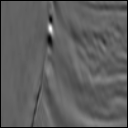

In [17]:
image_utils.array_to_img(x_test[n])

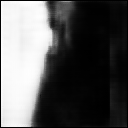

In [18]:
image_utils.array_to_img(pred_test[n])

## Create submission

In [22]:
import pandas as pd

In [8]:
preds_test_upsampled = []
for i in tqdm.tnrange(len(pred_test)):
    # Resize it back to original size: 101x101
    resized = resize(np.squeeze(pred_test[i]), (im_width, im_height), mode='constant', preserve_range=True)
    preds_test_upsampled.append(resized)

/Users/drodriguez/.local/share/virtualenvs/kaggle-salt-mKs4HKwM-/Users/drodriguez/.pyenv/shims/python/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [20]:
def run_length_enc(img, order='F', format=True):
    """
    img is binary mask image, shape (r, c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [21]:
pred_dict = {id_[:-4]: run_length_enc(np.round(preds_test_upsampled[i])) for i, id_ in tqdm.tqdm_notebook(enumerate(test_ids))}

In [23]:
sub = pd.DataFrame.from_dict(pred_dict, orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']

In [24]:
sub.head()

,rle_mask
id,
dc066ad24e,105 97 208 94 311 92 413 91 516 89 620 86 724 ...
9ddc91e5bb,103 99 204 99 305 99 406 99 507 99 608 99 709 ...
ef441205b5,4850 1 4951 7 5052 10 5153 11 5254 15 5355 15 ...
4a723a302f,
16545fae06,181 21 282 21 383 21 484 21 585 21 686 21 787 ...


In [25]:
sub.to_csv('submission.csv')